In [5]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

games = pd.read_csv("DataSets/games.csv")

In [45]:
# Cleaning the data
new_columns = []
for column in games.columns:
    new_columns.append(column.lower().strip())

games.columns = new_columns

games['user_score'] = games['user_score'].fillna('No_info')
games['rating'] = games['rating'].fillna('No_info')
mean_critic_score = round(games['critic_score'].mean())
games['critic_score'] = games['critic_score'].fillna(mean_critic_score)

games['genre'] = games['genre'].fillna('unknown')
games['year_of_release'] = games['year_of_release'].fillna(
    round(games['year_of_release'].mean()))
games['year_of_release'] = games['year_of_release'].astype('int')
games['name'] = games['name'].fillna('unknown')

La abreviatura "tbd" (proveniente de "to be determined") en la columna "user_score" probablemente indica que el juego aún no ha sido calificado; es decir, su puntuación está “por determinarse”. En cuanto a los valores NaN, es probable que representen que el videojuego nunca fue calificado o que el sitio web no cuenta con información disponible para ese campo en específico. Esto aplica a columnas como "user_score", "rating" y "critic_score".

Decidí rellenar los valores NaN de las columnas de tipo object con "No_info", y específicamente para las columnas "genre" y "name" utilicé el valor "unknown". Para la columna "critic_score", rellené los valores faltantes con la media de los valores existentes. Elegí esta imputación para mantener el tipo de dato float, ya que es más práctico para el análisis que convertirlo en un dato categórico. Además, usar la media no afecta de manera significativa el análisis posterior.

Finalmente, en la columna "year_of_release" también utilicé la media para rellenar los valores faltantes, redondeándola para asegurar que el año tuviera sentido. Luego convertí esta columna al tipo de dato int, lo cual, si bien no es estrictamente necesario, ayuda a mantener los datos más limpios y coherentes.


In [7]:
games['total_sales'] = games['na_sales']+games['eu_sales']+games['jp_sales']
games_per_year = games.groupby('year_of_release')['total_sales'].count(
).reset_index().sort_values(by='total_sales', ascending=False)
games_per_year.rename(columns={'total_sales': 'games_released'}, inplace=True)
print(games_per_year.head(10))

    year_of_release  games_released
28             2008            1427
29             2009            1426
26             2006            1275
30             2010            1255
27             2007            1197
31             2011            1136
25             2005             939
22             2002             829
23             2003             775
24             2004             762


No considero que la cantidad de juegos lanzados en un año sea un factor determinante para el futuro éxito de un videojuego que está por salir al mercado. Sin embargo, pueden existir casos especiales: por ejemplo, cuando un título muy esperado lanza su precuela en la misma fecha, o cuando varios juegos de gran relevancia compiten directamente entre sí. En situaciones como estas, el éxito de nuestro juego podría verse opacado por otros lanzamientos importantes. Por lo tanto, en casos de alta competencia, sería razonable reconsiderar la fecha de lanzamiento.


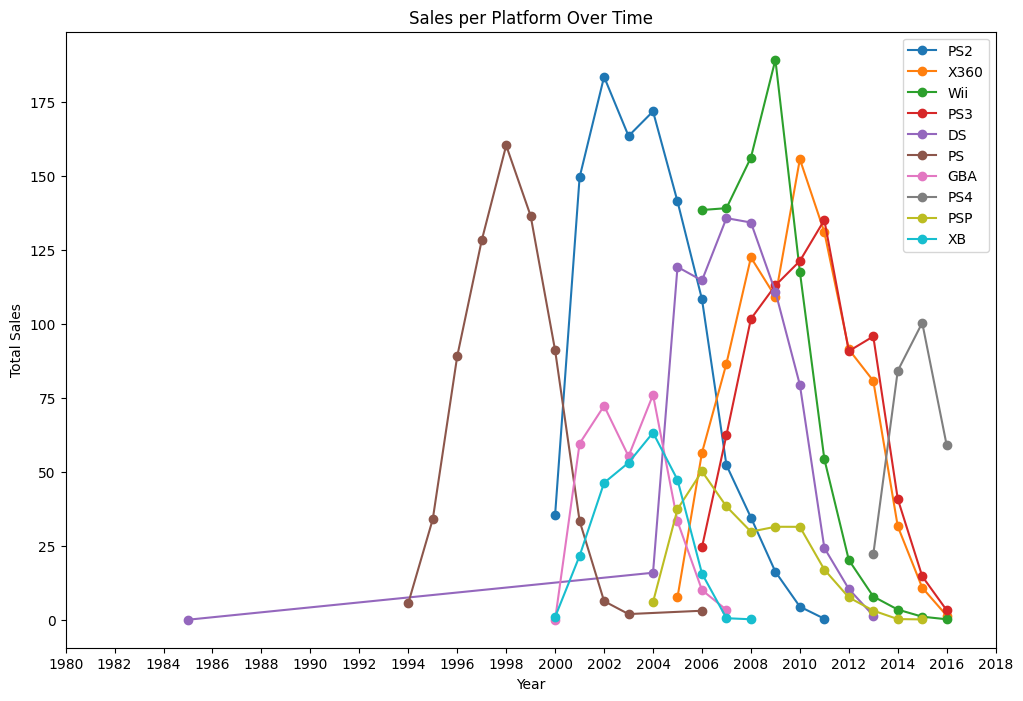

In [8]:
platform_sales = games.groupby('platform')['total_sales'].sum(
).reset_index().sort_values(by='total_sales', ascending=False)
top_platforms = platform_sales['platform'].head(10).tolist()
top_platform_data = games[games['platform'].isin(top_platforms)]
yearly_sales = top_platform_data.groupby(['platform', 'year_of_release'])[
    'total_sales'].sum().reset_index()

plt.figure(figsize=(12, 8))
for platform in top_platforms:
    platform_data = yearly_sales[yearly_sales['platform'] == platform]
    plt.plot(platform_data['year_of_release'], platform_data['total_sales'],
             marker='o', label=platform)

plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Sales per Platform Over Time')
plt.xticks(range(1980, 2019, 2))
plt.legend()
plt.show()

Todas las plataformas muestran una caída en ventas con el paso del tiempo. Sin embargo, la Wii es la que presenta el declive más marcado. A pesar de haber sido la consola más exitosa dentro de esta lista, sus ventas disminuyeron notablemente, al igual que las de la mayoría de las plataformas, alrededor del año 2016.

La plataforma que se ha mantenido con mayor estabilidad es la PS4, lo cual resulta lógico, ya que es una de las más recientes y está mejor alineada con las preferencias modernas del mercado.

En general, las plataformas suelen tener un ciclo de vida exitoso de entre 8 y 12 años antes de comenzar a perder relevancia o ser sustituidas por nuevas generaciones.


In [9]:
# Considero que los datos de años más recientes serán los más útiles para la campaña
relevant_years = [2010, 2011, 2012, 2013, 2014, 2015, 2016]
years_analisis = games[games['year_of_release'].isin(relevant_years)]

# Plataformas potencialmente rentables
profitable_platforms = ['PS4', 'PS3', 'X360', 'Wii']
profitable_platforms_data = years_analisis[years_analisis['platform']
                                           .isin(profitable_platforms)].sort_values(by='total_sales', ascending=False)

A partir de este punto trabajaré únicamente con los datos correspondientes a los años 2010 a 2016, y con los juegos de las plataformas PS4, PS3, X360 y Wii. Estas plataformas son las que tienen mayores probabilidades de seguir siendo relevantes en el futuro, ya que no han mostrado un declive tan marcado como las demás. Además, al pertenecer a años más recientes, sus juegos tienen más posibilidades de mostrar éxito, pues están mejor alineados con las preferencias del mercado actual.


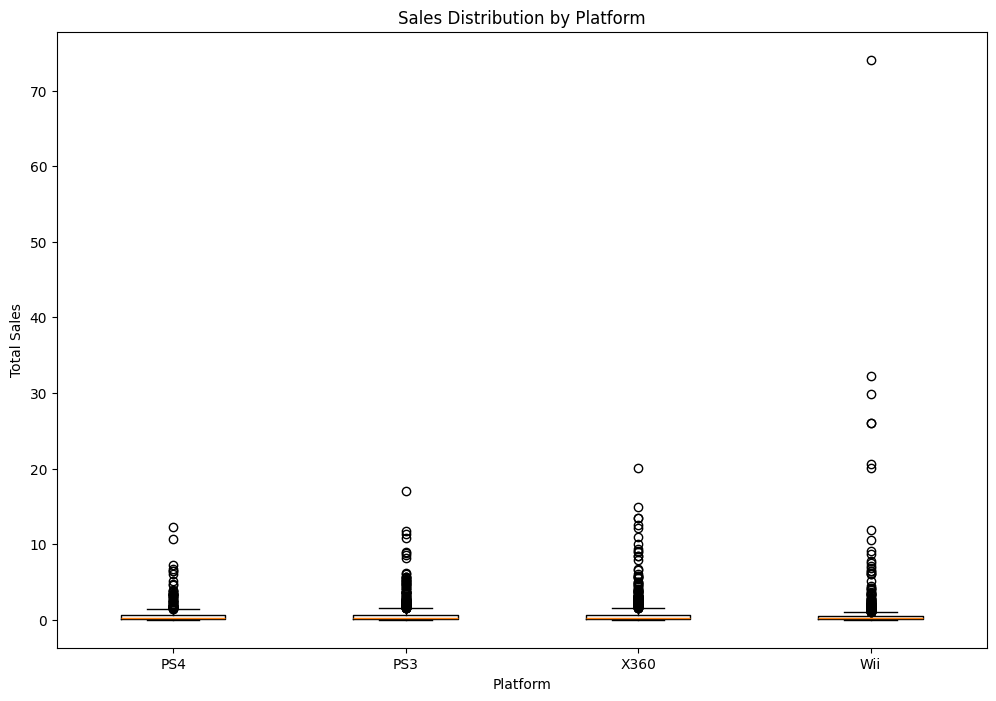

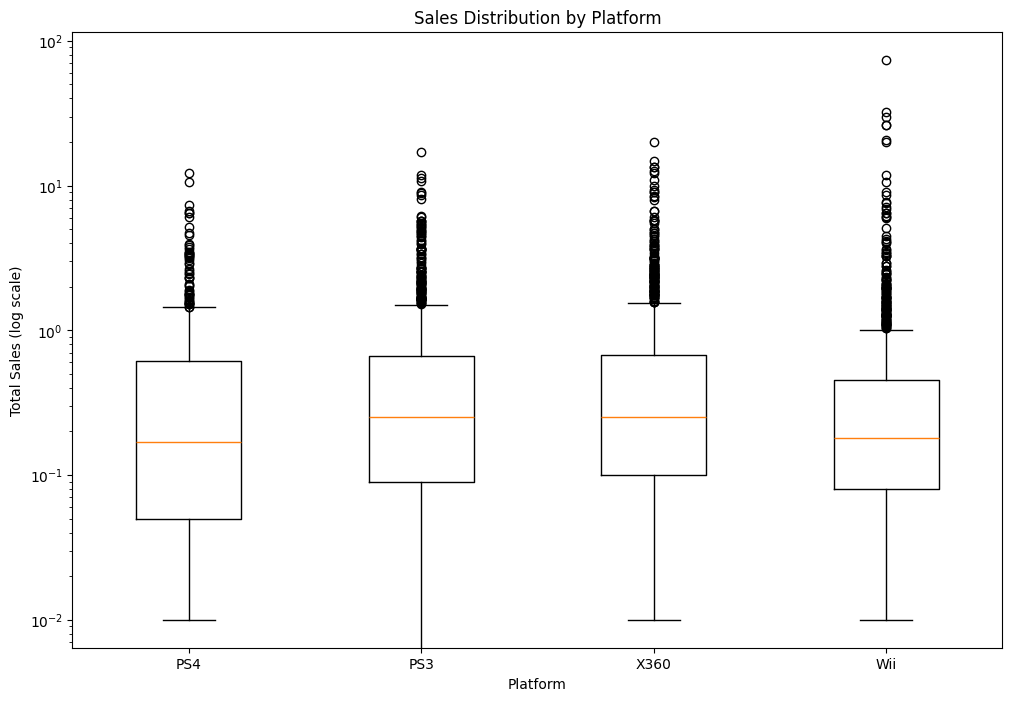

In [10]:
game_sales = games.groupby(['platform', 'name'])[
    'total_sales'].sum().reset_index()
filtered_game_sales = game_sales[game_sales['platform'].isin(
    profitable_platforms)]

plt.figure(figsize=(12, 8))

data = [filtered_game_sales[filtered_game_sales['platform'] == p]['total_sales']
        for p in profitable_platforms]


plt.boxplot(data, tick_labels=profitable_platforms)
plt.title('Sales Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.show()

# newcode

plt.figure(figsize=(12, 8))

data = [filtered_game_sales[filtered_game_sales['platform'] == p]['total_sales']
        for p in profitable_platforms]

plt.yscale('log')
plt.boxplot(data, tick_labels=profitable_platforms)
plt.title('Sales Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales (log scale)')
plt.show()

El cuerpo de caja tan compacto indica que la mayoría de los juegos en las plataformas analizadas venden aproximadamente lo mismo, aunque también existen demasiados valores extremos en todas la plataformas. Especialmente en la plataforma Wii.


Correlation coefficient between critics and total sales: 0.25
Correlation coefficient between critics from users and total sales: 0.15



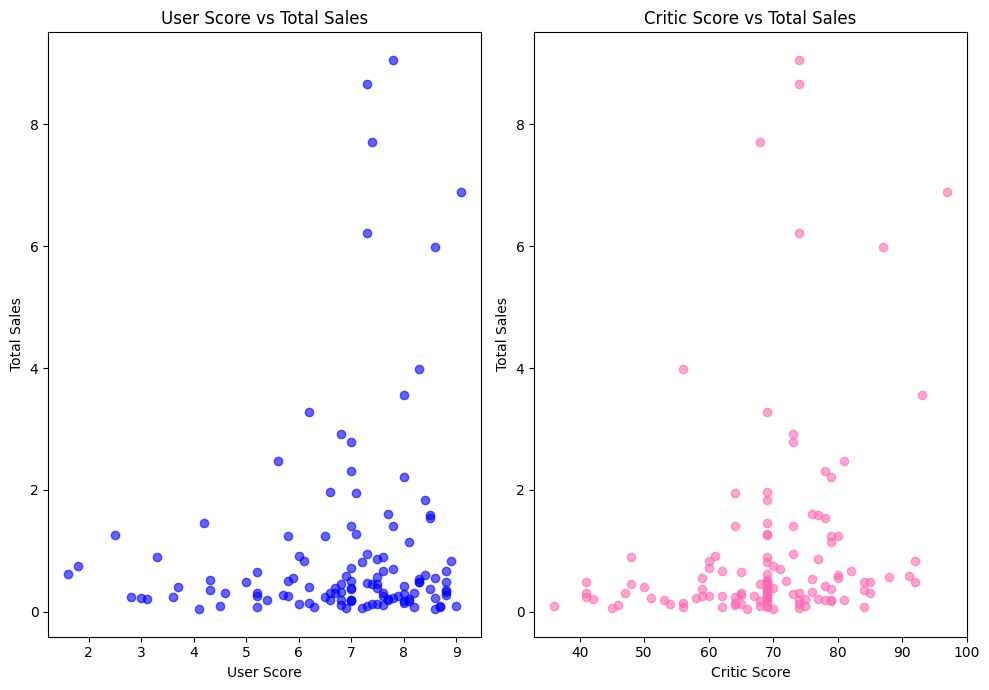

In [11]:
wii_platform = profitable_platforms_data[(profitable_platforms_data['platform'] == 'Wii')
                                         & (profitable_platforms_data['user_score'] != 'No_info')
                                         & (profitable_platforms_data['user_score'] != 'tbd')].copy()

wii_platform['user_score'] = pd.to_numeric(
    wii_platform['user_score']).astype(float)

print(
    f"Correlation coefficient between critics and total sales: {wii_platform['critic_score'].corr(wii_platform['total_sales']).round(3)}")
print(
    f"Correlation coefficient between critics from users and total sales: {wii_platform['user_score'].corr(wii_platform['total_sales']).round(3)}")
print()

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.scatter(wii_platform['user_score'],
            wii_platform['total_sales'], alpha=0.6, color='blue')
plt.xlabel('User Score')
plt.ylabel('Total Sales')
plt.title('User Score vs Total Sales')

plt.subplot(1, 2, 2)
plt.scatter(wii_platform['critic_score'],
            wii_platform['total_sales'], alpha=0.6, color='hotpink')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales')
plt.title('Critic Score vs Total Sales')

plt.tight_layout()
plt.show()

La correlación entre las ventas totales y las reseñas (tanto de usuarios como de críticos) es extremadamente débil.
Los coeficientes de correlación, que no superan 0.16, indican que prácticamente no existe una relación lineal entre estas variables.

Esto también se observa en los gráficos de dispersión: los puntos se encuentran distribuidos de forma desordenada y sin un patrón claro, lo que confirma que un mayor puntaje de críticas no garantiza mayores ventas en la plataforma Wii.


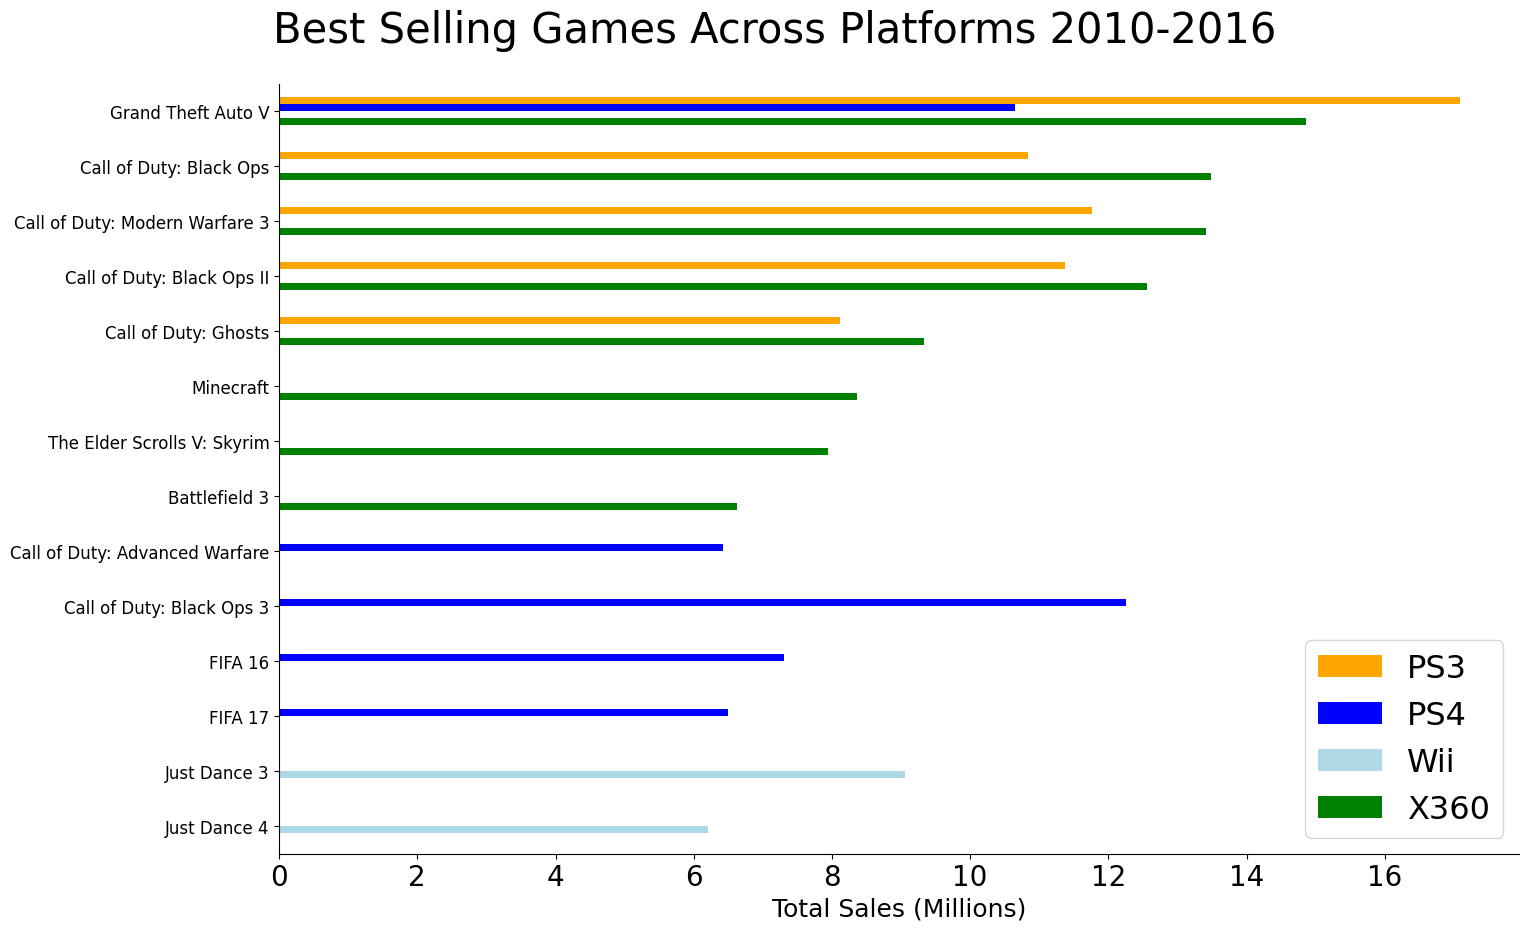

In [43]:
sales_per_platform = profitable_platforms_data.groupby(
    ['name', 'platform'])['total_sales'].sum().reset_index()
name_values = sales_per_platform['name'].value_counts().reset_index()
name_values.rename(
    columns={'index': 'name'}, inplace=True)
repeated_names = name_values[name_values['count'] > 1]
sales_repeated = (sales_per_platform
                  .merge(repeated_names, right_on='name', left_on='name', how='inner'))


top_repeated_games = sales_repeated.sort_values(
    'total_sales', ascending=False).head(20)

platform_sales_format = top_repeated_games.pivot_table(
    index='name',
    columns='platform',
    values='total_sales',
)

platform_sales_format = platform_sales_format.sort_values(
    by='X360',
    ascending=False
)
#plt.figure(figsize=(13, 20))
platform_sales_format.plot(
    kind='barh',
    figsize=(16, 10),
    width=0.5,
    color=['Orange', 'Blue', 'lightblue', 'Green']
)

plt.gca().invert_yaxis()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.ylabel("")
plt.xlabel('Total Sales (Millions)', fontsize=18)
plt.title('Best Selling Games Across Platforms 2010-2016', fontsize=30, x=0.4, pad=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.legend(fontsize=23)

plt.show()

El análisis comparativo de los juegos multiplataforma más vendidos entre 2010 y 2016 muestra un patrón claro en el desempeño de las distintas consolas. La X360 concentra, de forma consistente, las mayores ventas entre los títulos compartidos, lo que sugiere una base de usuarios más activa o una mejor posición en el mercado durante el periodo estudiado. La PS3 suele situarse en segundo lugar, manteniendo también un nivel de ventas sólido para la mayoría de estos juegos.

En contraste, la PS4 presenta una participación más limitada dentro de este grupo de títulos multiplataforma de alto rendimiento. Esto puede indicar que, en los años analizados, todavía se encontraba en una fase relativamente temprana de su ciclo de vida o que su catálogo de juegos compartidos exitosos era aún reducido. Por su parte, en la Wii, únicamente “Just Dance 3” aparece entre los juegos multiplataforma con ventas destacadas, lo que refuerza la idea de que muchos de sus mayores éxitos fueron títulos más específicos de su público objetivo, a menudo familiares o casuales.


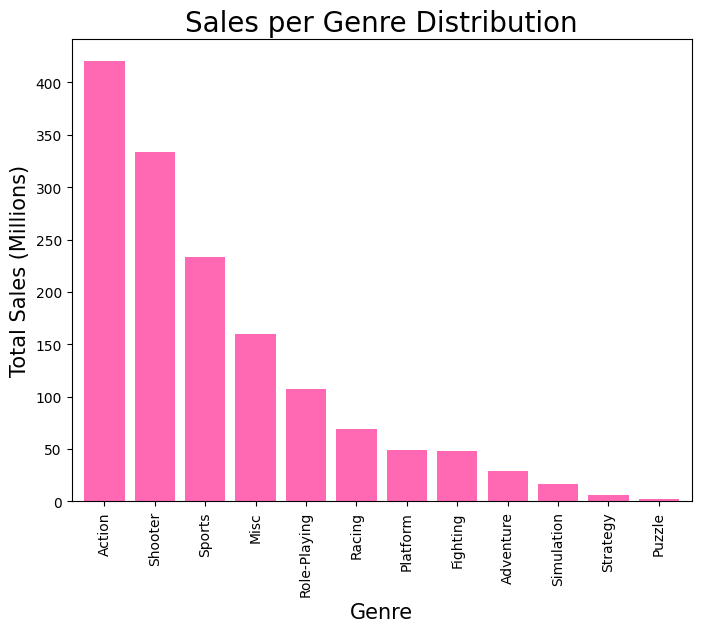

In [13]:
sales_per_genre = profitable_platforms_data.groupby('genre')['total_sales'].sum(
).reset_index().sort_values(by='total_sales', ascending=False)

# plt.figure(figsize=(12,8))
sales_per_genre.plot(
    kind='bar',
    x='genre',
    y='total_sales',
    color='hotpink',
    width=0.8,
    figsize=(8, 6),
)
plt.title('Sales per Genre Distribution', fontsize=20)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Total Sales (Millions)', fontsize=15)
plt.legend().remove()
plt.show()

Los géneros más vendidos son, sin duda, acción, deportes y shooter, mientras que los menos vendidos corresponden a acertijos y estrategia. Esto resulta lógico al observar las tendencias actuales del mercado: los juegos de acción dominan las listas de popularidad, mientras que los títulos de acertijos rara vez ocupan los primeros lugares.

En general, los juegos dinámicos y llenos de energía tienden a generar muchas más ventas, independientemente del género específico. Es probable que, hoy en día, muchos jugadores prefieran experiencias rápidas y estimulantes en lugar de dedicar tiempo a resolver acertijos complejos. Durante sus horas de juego, buscan más acción que reflexión profunda.


In [14]:
# Contiene las cinco plataformas más importantes

na_platform = (years_analisis.groupby('platform')['na_sales']
               .sum().reset_index().sort_values('na_sales', ascending=False))

eu_platform = (years_analisis.groupby('platform')['eu_sales']
               .sum().reset_index().sort_values('eu_sales', ascending=False))

jp_platform = (years_analisis.groupby('platform')['jp_sales']
               .sum().reset_index().sort_values('jp_sales', ascending=False))

main_na_platform = na_platform.head()
main_eu_platform = eu_platform.head()
main_jp_platform = jp_platform.head()

market_na = na_platform['na_sales'].sum().round(2)
market_eu = eu_platform['eu_sales'].sum().round(2)
market_jp = jp_platform['jp_sales'].sum().round(2)

# Análisis

xbox_japan = round(
    jp_platform[jp_platform['platform'] == 'X360']['jp_sales'].item(), 2)
xbox_na = round(na_platform[na_platform['platform']
                == 'X360']['na_sales'].item(), 2)
xbox_eu = round(eu_platform[eu_platform['platform']
                == 'X360']['eu_sales'].item(), 2)

psthree_japan = round(
    jp_platform[jp_platform['platform'] == 'PS3']['jp_sales'].item(), 2)
psthree_na = round(
    na_platform[na_platform['platform'] == 'PS3']['na_sales'].item(), 2)
psthree_eu = round(
    eu_platform[eu_platform['platform'] == 'PS3']['eu_sales'].item(), 2)


psfour_japan = round(
    jp_platform[jp_platform['platform'] == 'PS4']['jp_sales'].item(), 2)
psfour_na = round(
    na_platform[na_platform['platform'] == 'PS4']['na_sales'].item(), 2)
psfour_eu = round(
    eu_platform[eu_platform['platform'] == 'PS4']['eu_sales'].item(), 2)

wii_japan = round(
    jp_platform[jp_platform['platform'] == 'Wii']['jp_sales'].item(), 2)
wii_na = round(na_platform[na_platform['platform']
               == 'Wii']['na_sales'].item(), 2)
wii_eu = round(eu_platform[eu_platform['platform']
               == 'Wii']['eu_sales'].item(), 2)


print(f"La plataforma X360 en Japón solo conforma el "
      f"{round((xbox_japan*100)/market_jp, 2)}% mientras que en Norte América y \n"
      f"la Unión Europea ocupa hasta {round((xbox_na*100)/market_na, 2)}% y "
      f"{round((xbox_eu*100)/market_eu, 2)}%, respectivamente")
print()
print(f"La plataforma PS3 en Japón conforma el "
      f"{round((psthree_japan*100)/market_jp, 2)}% mientras que en Norte América y \n"
      f"la Unión Europea ocupa hasta {round((psthree_na*100)/market_na, 2)}% y "
      f"{round((psthree_eu*100)/market_eu, 2)}%, respectivamente")
print()
print(f"La plataforma PS4 en Japón solo conforma el "
      f"{round((psfour_japan*100)/market_jp, 2)}% mientras que en Norte América y \n"
      f"la Unión Europea ocupa hasta {round((psfour_na*100)/market_na, 2)}% y "
      f"{round((psfour_eu*100)/market_eu, 2)}%, respectivamente")
print()
print(f"La plataforma Wii en Japón conforma el "
      f"{round((wii_japan*100)/market_jp, 2)}% mientras que en Norte América y \n"
      f"la Unión Europea ocupa hasta {round((wii_na*100)/market_na, 2)}% y "
      f"{round((wii_eu*100)/market_eu, 2)}%, respectivamente")

La plataforma X360 en Japón solo conforma el 1.79% mientras que en Norte América y 
la Unión Europea ocupa hasta 29.56% y 19.43%, respectivamente

La plataforma PS3 en Japón conforma el 19.42% mientras que en Norte América y 
la Unión Europea ocupa hasta 20.28% y 25.39%, respectivamente

La plataforma PS4 en Japón solo conforma el 5.23% mientras que en Norte América y 
la Unión Europea ocupa hasta 9.62% y 16.77%, respectivamente

La plataforma Wii en Japón conforma el 5.82% mientras que en Norte América y 
la Unión Europea ocupa hasta 10.72% y 7.84%, respectivamente


In [15]:
genres_nasales = (profitable_platforms_data
                  .groupby('genre')['na_sales'].sum()
                  .reset_index().sort_values('na_sales', ascending=False))
genres_eusales = (profitable_platforms_data
                  .groupby('genre')['eu_sales'].sum()
                  .reset_index().sort_values('eu_sales', ascending=False))
genres_jpsales = (profitable_platforms_data
                  .groupby('genre')['jp_sales'].sum()
                  .reset_index().sort_values('jp_sales', ascending=False))

main_genres_nasales = genres_nasales.head()
main_genres_eusales = genres_eusales.head()
main_genres_jpsales = genres_jpsales.head()

print(main_genres_nasales.head())
print()
print(main_genres_eusales.head())
print()
print(main_genres_jpsales.head())

           genre  na_sales
0         Action    213.32
8        Shooter    186.35
10        Sports    131.51
3           Misc    100.23
7   Role-Playing     52.12

      genre  eu_sales
0    Action    175.68
8   Shooter    135.89
10   Sports     94.22
3      Misc     51.39
6    Racing     38.48

           genre  jp_sales
0         Action     31.14
7   Role-Playing     19.43
8        Shooter     11.72
3           Misc      7.99
10        Sports      7.86


Los géneros de los videojuegos en todos los continentes son casi los mismos, excepto en Japón, donde el género "Role-playing" aparece inesperadamente en el segundo lugar. Dejando atrás géneros como deportes y shooter.


In [16]:
rating_analysis = years_analisis.groupby(
    ['rating'])[['na_sales', 'eu_sales', 'jp_sales']].sum()
rating_analysis

,na_sales,eu_sales,jp_sales
rating,,,
E,271.15,197.34,47.87
E10+,159.38,99.28,13.22
EC,1.13,0.00,0.00
M,382.22,292.04,30.45
No_info,155.72,139.44,171.49
RP,0.00,0.03,0.00
T,160.81,113.08,42.11


Los juegos más vendidos son los que se sitúan en la categoría "M" (Mature) en norte américa y la unión europea, lo cual coincide completamente con las tendencias actuales. A diferencia de Japón, donde los juegos más vendidos son de la categoría "E" (Everyone). Aunque cabe destacar que la mayoria de los juegos en japón no se tiene información de su categoría.


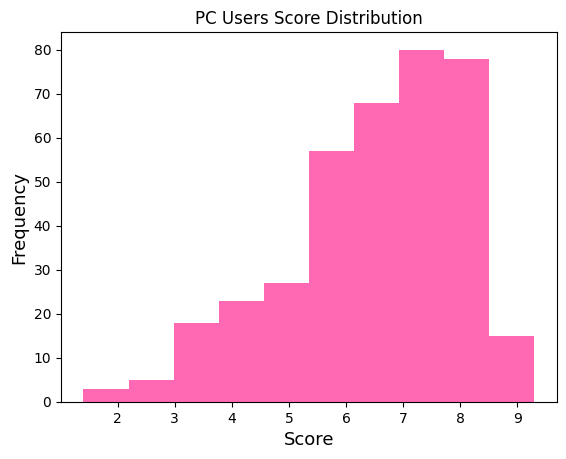

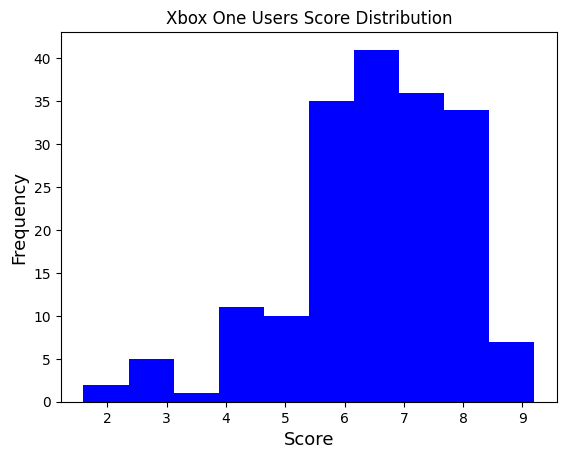

In [17]:
# Visualizando los datos

pc_users = years_analisis[(years_analisis['platform'] == 'PC') &
                          ~(years_analisis['user_score'].isin(['No_info', 'tbd']))]['user_score']
xone_users = years_analisis[(years_analisis['platform'] == 'XOne') &
                            ~(years_analisis['user_score'].isin(['No_info', 'tbd']))]['user_score']

pc_users = pd.to_numeric(pc_users).astype('float')
xone_users = pd.to_numeric(xone_users).astype('float')


pc_users.plot(
    kind='hist',
    color='hotpink',

)
plt.xlabel('Score', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('PC Users Score Distribution')
plt.show()

xone_users.plot(
    kind='hist',
    color='blue',
)
plt.xlabel('Score', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Xbox One Users Score Distribution')
plt.show()

## **📊 Verificación de Hipótesis**

<div style=" padding:15px; border-left:5px">
  <h3><strong> Primera Hipótesis</strong></h3>
  <p><em>"Las calificaciones promedio de los usuarios para las plataformas <strong>Xbox One</strong> y <strong>PC</strong> son las mismas".</em></p>
</div>


In [21]:

alpha = 0.05

levene_test = st.levene(pc_users, xone_users)
# El valor P del test de levene fue menor a alpha, por lo tanto se establecerá
# 'equal_var=False'

results = st.ttest_ind(pc_users, xone_users, equal_var=False)

print('Valor P: ', results.pvalue)

if results.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')

Valor P:  0.9801634129117883
No podemos rechazar la hipótesis nula


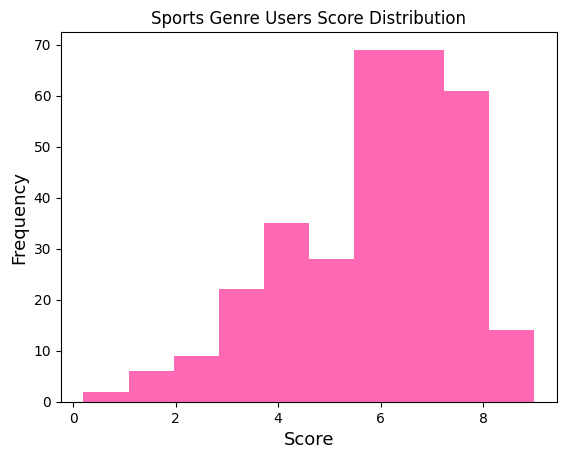

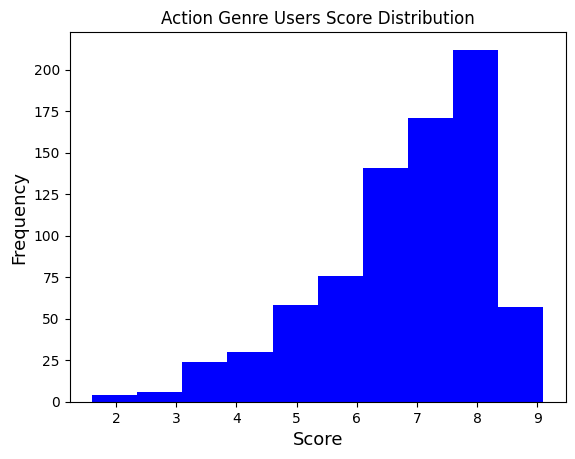

In [19]:
# Visualizando los datos

sports_scores = years_analisis[(years_analisis['genre'] == 'Sports') &
                               ~(years_analisis['user_score'].isin(['No_info', 'tbd']))]['user_score']

action_scores = years_analisis[(years_analisis['genre'] == 'Action') &
                               ~(years_analisis['user_score'].isin(['No_info', 'tbd']))]['user_score']

sports_scores = pd.to_numeric(sports_scores).astype('float')
action_scores = pd.to_numeric(action_scores).astype('float')


sports_scores.plot(
    kind='hist',
    color='hotpink',

)
plt.xlabel('Score', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Sports Genre Users Score Distribution')
plt.show()

action_scores.plot(
    kind='hist',
    color='blue',
    xlabel='Score'
)
plt.xlabel('Score', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Action Genre Users Score Distribution')
plt.show()

print()

<div style=" padding:15px; border-left:5px">
  <h3><strong> Segunda Hipótesis</strong></h3>
  <p><em>"Las calificaciones promedio de los usuarios para los géneros de <strong>Acción</strong> y <strong>Deportes</strong> son diferentes".</em></p>
</div>


In [20]:

alpha = 0.05

levene_test2 = st.levene(sports_scores, action_scores)

# El valor P del test de levene fue menor a alpha, por lo tanto se establecerá
# 'equal_var=False'

results2 = st.ttest_ind(sports_scores, action_scores, equal_var=False)

print('Valor P: ', results2.pvalue)


if results2.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')

Valor P:  1.451615246784441e-15
Rechazamos la hipótesis nula


Para ambas hipótesis utilicé el método ttest_ind, ya que, aunque las variables comparadas están relacionadas temáticamente, no provienen del mismo conjunto de datos y por tanto deben tratarse como muestras independientes.

En la primera prueba —sobre si las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas— era de esperarse que no pudiéramos rechazar la hipótesis nula. Desde los histogramas iniciales ambas distribuciones lucían prácticamente idénticas, lo cual sugería que no había diferencias significativas entre ellas.

En la segunda prueba —sobre si las calificaciones promedio de los usuarios para los géneros Acción y Deportes son diferentes— el comportamiento fue distinto. Al analizar los histogramas, ya se observaban más valores extremos en el género Acción, lo que indicaba mayor variabilidad. Los resultados estadísticos confirmaron esto: el valor p permitió rechazar la hipótesis nula, lo que respalda nuestra hipótesis inicial de que los promedios entre ambos géneros sí son diferentes.


## **Conclusión**


Durante el análisis se tomaron en cuenta los datos principalmente de los años 2010 a 2016 y las plataformas más rentables las cuales fueron PS4, PS3, X360 y Wii. Dichas plataformas son cruciales ya que son las que han tenido mejor desemepeño en años recientes.

Los géneros más rentables en las áreas analizadas son el género acción, shooter, sports, misc y role-playing. Lo cual coincide con el mercado actual, donde los juegos más éxitosos suelen ser muy dinámicos y llenos de elementos.

La plataforma más rentable en todas las áreas analizadas fue la PS3, además de ser la más equilibrada al promediar un 21.7% de cuota de mercado en Japón, la unión europea y norte américa. Aunque cabe resaltar que la X360 es más éxitosa que la PS3 en la unión europea y norte américa, pero en Japón tiene apenas un 1.79% de cuota de mercado.

Algo interesante a destacar, es que las críticas de usuarios y criticos no afectan las ventas de los juegos como se suele creer. Ya que se demostró que su correlación es prácticamente nula.

El juego más vendido de los años recientes y que tiene versión propia en más de una plataforma fue Grand Theft Auto V, seguido de Call of duty: Black Ops, Call of duty: Black Ops II y Call of duty: Black Ops 3. Sin duda la saga Call duty y grand theft auto se deben de tomar en cuenta para la futura campaña.

En la siguiente campaña se deben de tomar en cuenta juegos de los géneros acción, shooter, sports, misc y role-playing. Donde este último es especialmente importante en Japón. Además de que las sagas Call of duty y Grand Theft Auto deben estar en la portada para hacerles ver a los usuarios que sus juegos favoritos del momento están disponibles en nuestra plataforma "online Ice"
